## Goal

Segment data into static portions and motion trials for a simplified analysis

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

## Load the reference file

In [2]:
file_path_ref = 'ori_reference.log'
with open(file_path_ref, 'r') as file:
    lines = file.readlines()

## What does the data look like?

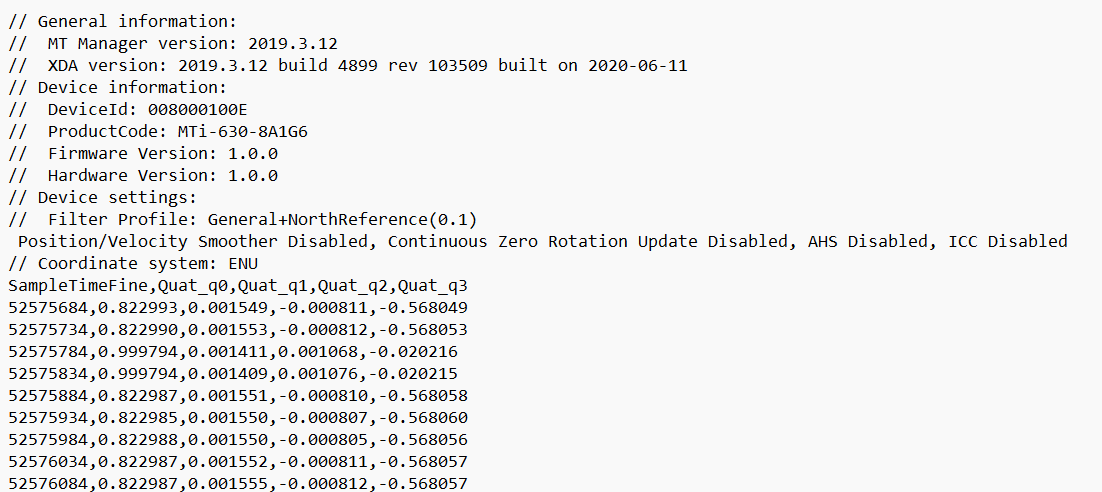

## Filter out lines from the reference file that start with "//"

In [3]:
filtered_lines = [line for line in lines if not line.strip().startswith('//')]

1. The one-line code above uses a list comprehension
2. List comprehensions provide compact one-line syntax for creating lists via for loops

## Write the filtered lines to a temporary CSV file

In [4]:
temp_file_path = 'filtered_data.csv'
with open(temp_file_path, 'w') as file:
    file.writelines(filtered_lines)

## Read the CSV file and specify that the first row contains the headers

In [5]:
df_ref = pd.read_csv(temp_file_path, header=1)

## How did we read the data?

In [6]:
type(df_ref)

pandas.core.frame.DataFrame

## What is a pandas DataFrame?

A pandas DataFrame is a data container that looks like an excel spreadsheet

In [7]:
df_ref.head()

,SampleTimeFine,Quat_q0,Quat_q1,Quat_q2,Quat_q3
0,52575684,0.822993,0.001549,-0.000811,-0.568049
1,52575734,0.822990,0.001553,-0.000812,-0.568053
2,52575784,0.999794,0.001411,0.001068,-0.020216
3,52575834,0.999794,0.001409,0.001076,-0.020215
4,52575884,0.822987,0.001551,-0.000810,-0.568058


## Extract and normalize reference timestamps

In [8]:
t_ref_raw_array = jnp.array(df_ref['SampleTimeFine'].values).reshape(-1, 1)
t_ref_array_full = 10**-4 * (t_ref_raw_array - t_ref_raw_array[0])

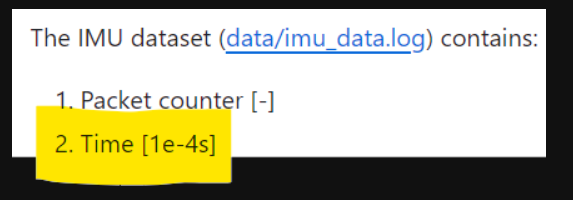

1. Normalization is a standardization procedure that makes our data easier to work with
2. We first extract the valued of the column from the data frame corresponding to the timestamps, convert it into a JAX numpy array (for compatibility with JAX) and then reshape it to a column vector so that the shape is well-defined
3. Next we convert the data to seconds by multiplying by 10**-4 based on the information provided on the assignment webpage
4. Finally we slice the data based on the start and end indices defined earlier

## Extract reference orientation data

In [9]:
data_quat_full = jnp.array(df_ref[list(df_ref.columns[1:])].values.tolist())

## What are quaternions?

1. Quaternions are four-dimensional mathematical structures
2. Their workings can be understood from an algebraic perspective
3. The three-dimensional geometric operations of vector dot and cross products can be viewed as a consequence of the algebraic properties of the four-dimensional quaternions
4. This consequence finds application in motivating the connection between three-dimensional rotations and quaternions
5. Quaternions are an effective way of dealing with three-dimensional rotations and their time derivatives
6. We will code up some of the basic properties of quaternions like conjugation, products and derivatives
7. The quaternion operations that we code up will be an important part of our workflow

## Function to convert quaternion to roll, pitch, yaw

In [10]:
def quat_to_rpy(quat):
    w, x, y, z = quat
    roll = jnp.arctan2(2.0 * (w * x + y * z), 1.0 - 2.0 * (x * x + y * y))
    pitch = jnp.arcsin(2.0 * (w * y - z * x))
    yaw = jnp.arctan2(2.0 * (w * z + x * y), 1.0 - 2.0 * (y * y + z * z))
    return jnp.array([roll, pitch, yaw])

## Vectorized conversion

In [11]:
rpy_angles_rad = jax.vmap(quat_to_rpy)(data_quat_full)

Converting quaternions to inclination (roll and pitch) and heading angles are a great example of vectorizing a custom function via the vmap feature provided by JAX for massive speed-up!

## Convert the angles from radians to degrees

In [12]:
rpy_angles_deg = jnp.degrees(rpy_angles_rad)

## Notes on conversion formula

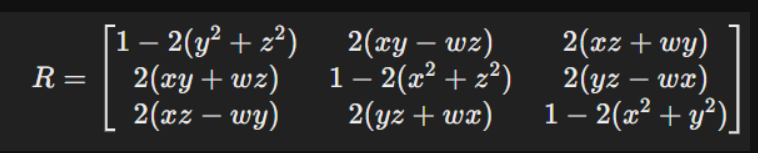

1. The Rodrigues rotation formula can be used to derive a rotation matrix for a given axis-angle representation
2. The axis-angle form can be easily represented as a quaternion
3. Thus the rotation matrix derived from Rodriguez rotation formula can be expressed in terms of the quaternion components
4. The first and second columns of the rotation matrix are the major and minor axes of the IMU respectively
5. These axes are unit vectors
6. The pitch is the counter-clokwise angle made by the major axis with respect to the horizontal (EN) plane of the ENU frame and given that the major axis is a unit vector - it is simply the negative of the inverse sine of the z (up) component of the first column
7. The yaw is the counter-clockwise rotation of the major axis about the z (up) axis and is simply given by the inverse tangent of the ratio of the y-component of the major axis to its x-component
8. The roll is the counter-clockwise rotation about the x (east) axis and is given by the negative of the inverse tangent of the ratio of the y-component of the final IMU axis to its z-component

## Load the file

In [13]:
file_path = 'imu_data.log'
with open(file_path, 'r') as file:
    data = file.readlines()

## What does the data look like?

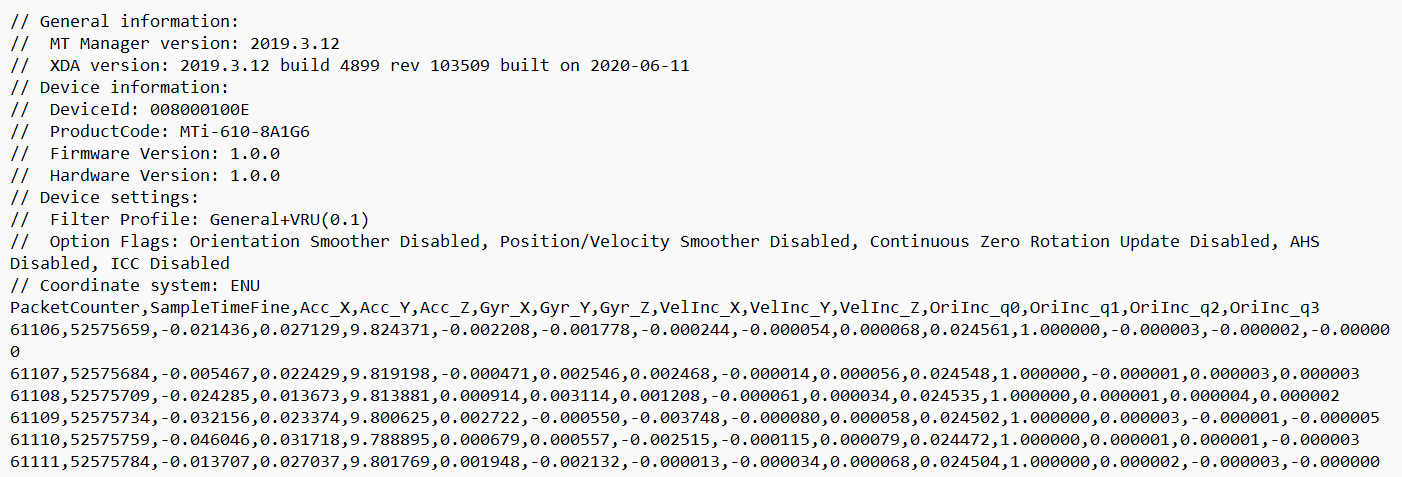

## Locate where the actual data starts

In [14]:
data_start_index = None
for index, line in enumerate(data):
    if not line.startswith('//'):
        data_start_index = index
        break

## Read the data into a DataFrame, skipping the initial metadata lines

In [15]:
df = pd.read_csv(file_path, skiprows=data_start_index)

In [16]:
df.head()

,PacketCounter,SampleTimeFine,Acc_X,Acc_Y,Acc_Z,Gyr_X,Gyr_Y,Gyr_Z,VelInc_X,VelInc_Y,VelInc_Z,OriInc_q0,OriInc_q1,OriInc_q2,OriInc_q3
0,61106,52575659,-0.021436,0.027129,9.824371,-0.002208,-0.001778,-0.000244,-0.000054,0.000068,0.024561,1.0,-0.000003,-0.000002,-0.000000
1,61107,52575684,-0.005467,0.022429,9.819198,-0.000471,0.002546,0.002468,-0.000014,0.000056,0.024548,1.0,-0.000001,0.000003,0.000003
2,61108,52575709,-0.024285,0.013673,9.813881,0.000914,0.003114,0.001208,-0.000061,0.000034,0.024535,1.0,0.000001,0.000004,0.000002
3,61109,52575734,-0.032156,0.023374,9.800625,0.002722,-0.000550,-0.003748,-0.000080,0.000058,0.024502,1.0,0.000003,-0.000001,-0.000005
4,61110,52575759,-0.046046,0.031718,9.788895,0.000679,0.000557,-0.002515,-0.000115,0.000079,0.024472,1.0,0.000001,0.000001,-0.000003


## Normalize timestamps

In [17]:
t_array = np.array(df['SampleTimeFine'].values)
t_normalized_array = 10**-4 *(t_array - t_array[0])

## Extract accelerometer and gyroscope data

In [18]:
data_acc = np.array(df[['Acc_X', 'Acc_Y', 'Acc_Z']].values.tolist())
data_gyro = np.array(df[['Gyr_X', 'Gyr_Y', 'Gyr_Z']].values.tolist())

## Extract movement trials

In [19]:
print("Extracting movement trials...")

Extracting movement trials...


## List to store the start and end indices of movement trials

In [20]:
start_idx_list = []
end_idx_list = []

## Parameters

In [21]:
window_size = 500
error_size = 2*window_size
std_threshold = 1.0
constant_jump = 9.81
threshold_jump = 10**-1

The choice of parameters was purely empirical

## Function to compute the standard deviation of a window

In [22]:
def window_std(data, start_idx, window_size):
    return np.std(data[start_idx:start_idx + window_size])

## Standard deviation window-based algorithm

In [23]:
data_jump = data_acc[:,2]

current_state = "start"
for i in range(1, len(data_acc) - window_size - 1):
    current_std = window_std(data_acc[:, 2], i, window_size)
    left_std = window_std(data_acc[:, 2], i - window_size, window_size)
    right_std = window_std(data_acc[:, 2], i + window_size, window_size)
    
    current_std = window_std(data_jump, i, window_size)
    left_std = window_std(data_jump, i - window_size, window_size)
    right_std = window_std(data_jump, i + window_size, window_size)
    
    if current_state == "start":
        
        if current_std > std_threshold and left_std < std_threshold and right_std > std_threshold:
            
            bool_start_zero = np.abs(np.mean(np.abs(data_acc[i-window_size:i, 0])) - constant_jump) < threshold_jump
            bool_start_one = np.abs(np.mean(np.abs(data_acc[i-window_size:i, 1])) - constant_jump) < threshold_jump
            bool_start_two = np.abs(np.mean(np.abs(data_acc[i-window_size:i, 2])) - constant_jump) < threshold_jump
            
            if bool_start_zero or bool_start_one or bool_start_two:
                start_idx = i - error_size
                start_idx_list.append(start_idx)
                current_state = "end"
                
    else:
        
        if current_std < std_threshold and left_std > std_threshold and right_std < std_threshold:
            
            bool_end_zero = np.abs(np.mean(np.abs(data_acc[i:i+window_size, 0])) - constant_jump) < threshold_jump
            bool_end_one = np.abs(np.mean(np.abs(data_acc[i:i+window_size, 1])) - constant_jump) < threshold_jump
            bool_end_two = np.abs(np.mean(np.abs(data_acc[i:i+window_size, 2])) - constant_jump) < threshold_jump
            
            if bool_end_zero or bool_end_one or bool_end_two:
                end_idx = i + error_size
                end_idx_list.append(end_idx)
                current_state = "start"

C:\Users\naren\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\naren\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\naren\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1. Motion trials are extracted from the time series using a conventional signal processing technique
2. This technique is based on identifying jumps in the standard deviation of a sliding window and deviations of its mean from a baseline
3. This code aims to identify the start and end points of significant jumps or changes in accelerometer data by analyzing the z-axis readings
4. Initially, the code sets the variable "data_jump" to the z-axis data and initializes the "current_state" as "start"
5. It then iterates over the data points, calculating the standard deviation for a window centered at each point, as well as the standard deviations for the windows immediately to the left and right of the center point
6. When the current_state is "start", the code checks if current_std is greater than a specified threshold, while left_std is less than the threshold and right_std is greater than the threshold
7. If these conditions are met, it suggests a potential start of a jump
8. To confirm this, the code checks if the mean absolute values of the accelerometer data within the window are close to a defined constant using a given threshold for all three axes
9. If any of these conditions are satisfied, the start index is recorded within an error margin and appended to a list while the current state is switched to "end"
10. When in the "end" state - the algorithm looks for the opposite pattern as this suggests a potential end of a jump
11. The accelerometer data based checks similar to detecting the start of a jump are performed to detect the end of the jump
12. If these checks are passed, the end index is recorded within an error margin and appended to a list
13. The current state is switched back to "start" and the process continues till the end of the time series is reacheds.

## Output the result

In [24]:
print("Start indices of movement trials:", start_idx_list)
print("End indices of movement trials:", end_idx_list)
print("----------------------------------")

Start indices of movement trials: [5530, 65425, 89728, 109876, 129086, 145223, 157175, 174895, 203979, 219302, 236081, 261587]
End indices of movement trials: [64481, 68081, 92346, 112377, 132121, 148485, 161354, 181312, 206868, 222175, 240078, 264468]
----------------------------------


## Manual correction

In [25]:
end_idx_list[9] += 2000
end_idx_list[10] += 2000
end_idx_list.pop(0)
start_idx_list.pop(1)
end_idx_list[0] += 2000

## Define arrays for orientation estimates

In [26]:
roll_estimates = np.full(t_normalized_array.shape, np.nan)
pitch_estimates = np.full(t_normalized_array.shape, np.nan)
yaw_estimates = np.full(t_normalized_array.shape, np.nan)

roll_estimates[0] = 0
pitch_estimates[0] = 0
yaw_estimates[0] = 0

est_end_idx_list = [0] + end_idx_list
est_start_idx_list = start_idx_list + [len(t_normalized_array)-1]

1. We initialize the orientation estimate containers by assigning them arrays the size of the time series populated with NaNs
2. We assume that the IMU is intially at rest and set the orientation estimates at the first index to be zero
3. Since we are are planning on populating these containers for the static portions - we need to simultaneously iterate through the end and start indices list corresponding to the motion trials
4. The first static part does not have a corresponding "end" so we append zero to the left of the end indices list
5. The last static part does not have a corresponding "start" so we append the last index to right of the start indices list

## Populate orientation estimate arrays during static trials

Orientation estimates for the static portions based on accelerometer signal values during these periods

In [27]:
for (e,s) in zip(est_end_idx_list, est_start_idx_list):
    yaw_estimates[e+1:s] = 0
    if np.abs(np.mean(data_acc[e:s,1]) - 9.81) < 0.3:
        roll_estimates[e+1:s] = 90
        pitch_estimates[e+1:s] = 0
    elif np.abs(np.mean(data_acc[e:s,1]) + 9.81) < 0.3:
        roll_estimates[e+1:s] = -90
        pitch_estimates[e+1:s] = 0
    elif np.abs(np.mean(data_acc[e:s,0]) - 9.81) < 0.3:
        roll_estimates[e+1:s] = 0
        pitch_estimates[e+1:s] = -90
    elif np.abs(np.mean(data_acc[e:s,0]) + 9.81) < 0.3:
        roll_estimates[e+1:s] = 0
        pitch_estimates[e+1:s] = 90
    else:
        roll_estimates[e+1:s] = 0
        pitch_estimates[e+1:s] = 0

1. This code processes accelerometer data to estimate the orientation of a sensor during the static portions
2. We acccess the static portions by simultaneously iterating over the end and start indices lists corresponding to the motion trial via "zip"
3. During the static periods the accelerometer readings are assumed to be based on gravity
4. No information in the plane normal to the gravitational vector can be obtained and therefore the yaw is set to zero
5. If the minor axis of the IMU aligns with the up/down direction, we can expect the roll to be +90/-90, the pitch to be zero and the y-component of the accelerometer reading to be within some error of +9.81/-9.81
6. If instead the major axis of the IMU shows similar patterns, we can expect the pitch be -90/+90 and the roll to be zero - the sign flip is because the alignment of the major axis with the up direction is related to a clockwise rotation and our convention associated positive values to a counter-clockwise rotation sense
7. If none of the above conditions hold, the IMU axes are aligned with the ENU parent frame and all rotation angles are zero
8. Note that our array slicing runs from "e+1" to "s" as "e" is not included meaning that we need to start at "e+1" and neither is "s" included but ending at "s" handles that just because of how syntax in Python is structured

## Plot roll

Text(0.5, 1.0, 'Roll (static portions)')

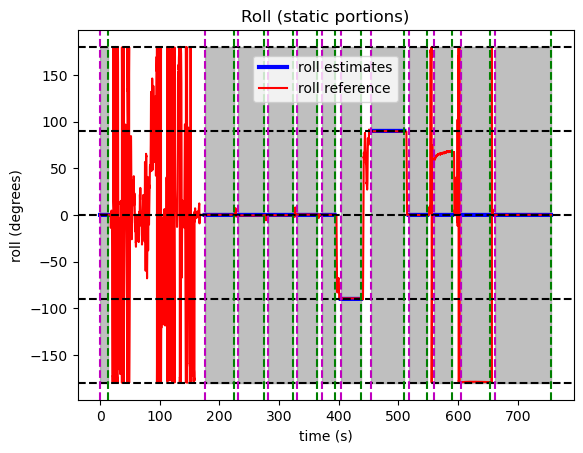

In [28]:
plt.figure()
plt.plot(t_normalized_array, roll_estimates, color='b', linewidth=3, label='roll estimates')
plt.plot(t_ref_array_full, rpy_angles_deg[:,0], 'r', label='roll reference')
plt.axhline(y=180, color='k', linestyle='--')
plt.axhline(y=90, color='k', linestyle='--')
plt.axhline(y=-90, color='k', linestyle='--')
plt.axhline(y=-180, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='--')
for (e,s) in zip(est_end_idx_list, est_start_idx_list):
    x1_val = t_normalized_array[e]
    x2_val = t_normalized_array[s]
    plt.axvline(x=x1_val, color='m', linestyle='--')
    plt.axvline(x=x2_val, color='g', linestyle='--')
    plt.fill_betweenx(y=[-180, 180], x1=x1_val, x2=x2_val, color='grey', alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95))
plt.xlabel("time (s)")
plt.ylabel("roll (degrees)")
plt.title("Roll (static portions)")

## Plot pitch

Text(0.5, 1.0, 'Pitch (static portions)')

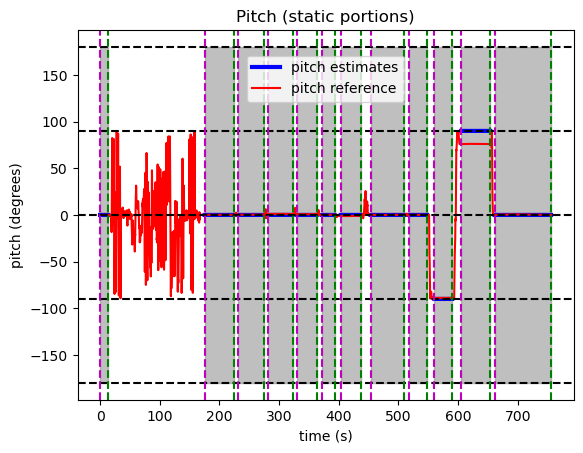

In [29]:
plt.figure()
plt.plot(t_normalized_array, pitch_estimates, color='b', linewidth=3, label='pitch estimates')
plt.plot(t_ref_array_full, rpy_angles_deg[:,1], 'r', label='pitch reference')
plt.axhline(y=180, color='k', linestyle='--')
plt.axhline(y=90, color='k', linestyle='--')
plt.axhline(y=-90, color='k', linestyle='--')
plt.axhline(y=-180, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='--')
for (e,s) in zip(est_end_idx_list, est_start_idx_list):
    x1_val = t_normalized_array[e]
    x2_val = t_normalized_array[s]
    plt.axvline(x=x1_val, color='m', linestyle='--')
    plt.axvline(x=x2_val, color='g', linestyle='--')
    plt.fill_betweenx(y=[-180, 180], x1=x1_val, x2=x2_val, color='grey', alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95))
plt.xlabel("time (s)")
plt.ylabel("pitch (degrees)")
plt.title("Pitch (static portions)")

## Plot yaw

Text(0.5, 1.0, 'Yaw (static portions)')

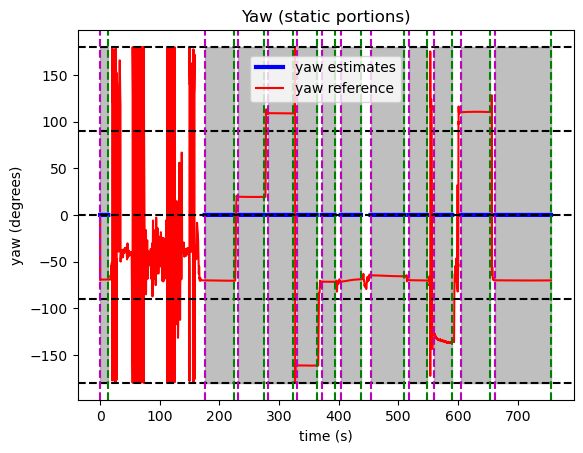

In [30]:
plt.figure()
plt.plot(t_normalized_array, yaw_estimates, color='b', linewidth=3, label='yaw estimates')
plt.plot(t_ref_array_full, rpy_angles_deg[:,2], 'r', label='yaw reference')
plt.axhline(y=180, color='k', linestyle='--')
plt.axhline(y=90, color='k', linestyle='--')
plt.axhline(y=-90, color='k', linestyle='--')
plt.axhline(y=-180, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='--')
for (e,s) in zip(est_end_idx_list, est_start_idx_list):
    x1_val = t_normalized_array[e]
    x2_val = t_normalized_array[s]
    plt.axvline(x=x1_val, color='m', linestyle='--')
    plt.axvline(x=x2_val, color='g', linestyle='--')
    plt.fill_betweenx(y=[-180, 180], x1=x1_val, x2=x2_val, color='grey', alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95))
plt.xlabel("time (s)")
plt.ylabel("yaw (degrees)")
plt.title("Yaw (static portions)")